In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline


Inspired by biological neural networks in animal brains, Artificial Neural Networks (ANN) are the result of decades of computational model adaptations and discoveries to create a powerful computing system that mimics "learning" through example without specified rules. The invention of the perceptron model (1957, F. Rosenblatt), a method involving learnable weights and thresholds, laid key theoretical foundations that were integral to ANNs. Because single layer perceptrons were unable to handle the "exclusive or" (XOR) problem by effectively predicting the outputs of non-linearly seperable datasets. The introduction of backpropagation for training multiple-layered perceptrons allowed for networks to learn nonlinear decision boundaries by stacking multiple layers of neurons, or nodes.

ANNs are comprised of at least three layers of nodes: an input layer (i) that recieves the raw features, at least one "hidden" layer (j) that performs intermediate transformation, and an output layer (k) that applies the activation function to produce a prediction. When connections are feedforward, as in multilayer perceptron (MLP) (informaiton moves in a single direction, layer by layer, with no feedback loop) and trained using a backpropagation algorithm. 


**Feedforward Computation**

Each hidden node computes a scalar net activation using the weighted sum of the inputs.

$$
\text{net}_j = \sum_i x_i w_{ij} = \mathbf{w}_j^\top \mathbf{x}
$$

$w_ij$ is the input-to-hidden layer weight at node $j$, and $x$ is the input vector.

An output for each hidden node is computed from a function *f* of its activation, where the activation function is a nonlinear function that is both continous and differentiable. Common choices include signmoid, tanh, and ReLU.

$$
z_j = f(net_j)
$$

Lastly, the output nodes calculate the net activation based on the outputs of the hidden nodes. 
$$
\text{net}_k = \sum_{j=1}^{N_h} z_j w_{kj} = \mathbf{w}_k^\top \mathbf{z}
$$

prediction $y_k$ is the activation of $net_k$. Often, for multi-class problems, softmax function is applied.


**Backpropagation and Weight updates**

Training involves minimizing the loss function.

$$
\mathcal{L}=-\sum _{k=1}^Ky_k\log (\hat {y}_k)
$$
In the backpropagation pass, error is calculated by the difference between the predicted output from the network from the actual target. The gradients of the loss function with respect to each weight are applyed by using the chain rule in reverse, beginning with the output layer, to the hidden, and lastly through the input layer. The sensitivity of each node quantifies how much the error changes with respect to activition and are used to update the weights via gradient descent.



The output layer sensitivity is defined by:

$$
\delta_k = \hat{y}_k - y_k
$$

Hidden Layer sensitivity:

$$
\delta_j = f'(net_j) \sum_k \delta_k w_{kj}
$$

Therefore, the weight gradient is calculated by:
$$
\frac{\partial E}{\partial w_{ij}} = \delta_j x_i
$$

Weights are updated using the gradient descent method, where $\eta$ is the learning rate:

$$
w^{\tau + 1} = w^{\tau} - \eta \nabla E(w^{\tau})
$$




In [6]:
df=pd.read_csv('../../data/processed/winequality-red-normalized.csv')
df_normalized = pd.read_csv('../../data/processed/winequality-red-normalized.csv')
df_interactions = pd.read_csv('../../data/processed/winequality-red-interactions.csv')
df_pca = pd.read_csv('../../data/processed/winequality-red-pca.csv')

X_norm = df_normalized.drop('quality', axis=1)
y_norm = df_normalized['quality']

X_inter = df_interactions.drop('quality', axis=1)
y_inter = df_interactions['quality']

X_pca = df_pca.drop('quality', axis=1)
y_pca = df_pca['quality']

In [8]:
datasets = {
    "Normalized": (X_norm, y_norm),
    "Interactions": (X_inter, y_inter),
    "PCA": (X_pca, y_pca)
}
# param_grid = {
#     "hidden_layer_sizes": [(64,), (64, 32), (128, 64)],
#     "activation": ["logistic", "tanh","relu"],
#     "alpha": [1e-5, 1e-4, 1e-3],
#     "learning_rate_init": [5e-4, 1e-3, 2e-3],
#     "solver": ["adam","sgd"]
# }
param_grid = {
    "hidden_layer_sizes": [(64,), (128, 64)],
    "activation": ["relu", "tanh", "logistic"], 
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [0.0005, 0.001, 0.002, 0.005],
    "learning_rate": ["constant", "adaptive", "invscaling"],
    "solver": ["adam", "lbfgs"],
    "max_iter": [500, 1000],
    "early_stopping": [True]
}

results = {}

for name, (X, y) in datasets.items():
    print(f"\n{'='*60}")
    print(f"Training ANN on {name} dataset")
    print(f"{'='*60}")
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Grid search
    ann = MLPClassifier(max_iter=600, early_stopping=True, n_iter_no_change=20, random_state=42)
    grid = GridSearchCV(
        ann,
        param_grid,
        cv=5, 
        scoring="f1_macro", 
        n_jobs=-1, 
        verbose=1)
    grid.fit(X_train, y_train)
    
    best_ann = grid.best_estimator_
    y_pred = best_ann.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    cv_scores = cross_val_score(best_ann, X_train, y_train, cv=5, scoring="f1_macro")
    
    # Store results
    results[name] = {
        "best_params": grid.best_params_,
        "accuracy": acc,
        "f1_macro": f1m,
        "cv_mean": cv_scores.mean(),
        "cv_std": cv_scores.std(),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred, digits=4,zero_division=0)
    }
    
    # Print
    print(f"\nBest parameters: {grid.best_params_}")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Macro F1-Score: {f1m:.4f}")
    print(f"CV Macro F1: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print("\nConfusion Matrix:\n", results[name]["confusion_matrix"])
    print("\nClassification Report:\n", results[name]["report"])


Training ANN on Normalized dataset
Fitting 5 folds for each of 864 candidates, totalling 4320 fits

Best parameters: {'activation': 'logistic', 'alpha': 1e-05, 'early_stopping': True, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.0005, 'max_iter': 500, 'solver': 'lbfgs'}
Test Accuracy: 0.6531
Macro F1-Score: 0.3951
CV Macro F1: 0.3723 (+/- 0.0822)

Confusion Matrix:
 [[ 0  0  1  1  0  0]
 [ 0  1  4  6  0  0]
 [ 0  8 97 25  6  0]
 [ 0  1 26 87 14  0]
 [ 0  1  1 13 23  2]
 [ 0  0  1  0  1  1]]

Classification Report:
               precision    recall  f1-score   support

           3     0.0000    0.0000    0.0000         2
           4     0.0909    0.0909    0.0909        11
           5     0.7462    0.7132    0.7293       136
           6     0.6591    0.6797    0.6692       128
           7     0.5227    0.5750    0.5476        40
           8     0.3333    0.3333    0.3333         3

    accuracy                         0.6531       320
   

In [11]:
# Convert results dict to DataFrame
summary = pd.DataFrame.from_dict(results, orient='index')

# Select only the columns you want in the table
summary_table = summary[[
    'best_params',
    'accuracy',
    'f1_macro',
    'cv_mean',
    'cv_std'
]]

print("\n=== ANN Results Summary ===")
print(summary_table)


=== ANN Results Summary ===
                                                    best_params  accuracy  \
Normalized    {'activation': 'logistic', 'alpha': 1e-05, 'ea...  0.653125   
Interactions  {'activation': 'logistic', 'alpha': 1e-05, 'ea...  0.593750   
PCA           {'activation': 'tanh', 'alpha': 0.0001, 'early...  0.637500   

              f1_macro   cv_mean    cv_std  
Normalized    0.395069  0.372300  0.041097  
Interactions  0.386555  0.353134  0.039188  
PCA           0.418152  0.368735  0.061540  


In [16]:
#difference in best run, from adam to lbfgs
X_inter_train, X_inter_test, y_inter_train, y_inter_test = train_test_split(
    X_inter, y_inter, test_size=0.2, random_state=42, stratify=y_inter
)

ann_adam = MLPClassifier(
    hidden_layer_sizes=(64,), 
    activation="tanh", 
    alpha=0.00001, 
    learning_rate_init=0.002, 
    solver="adam", 
    max_iter=1000, 
    random_state=42,
    early_stopping= True
)
ann_adam.fit(X_inter_train, y_inter_train)
y_pred_adam = ann_adam.predict(X_inter_test)
f1_adam = f1_score(y_inter_test, y_pred_adam, average="macro")

# --- LBFGS run on PCA dataset ---
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca
)

ann_lbfgs = MLPClassifier(
    hidden_layer_sizes=(64,), 
    activation="tanh", 
    alpha=0.0001, 
    learning_rate_init=0.0005, 
    solver="lbfgs", 
    max_iter=1000, 
    random_state=42,
    early_stopping= True
)
ann_lbfgs.fit(X_pca_train, y_pca_train)
y_pred_lbfgs = ann_lbfgs.predict(X_pca_test)
f1_lbfgs = f1_score(y_pca_test, y_pred_lbfgs, average="macro")

# Percent improvement
percent_improvement = ((f1_lbfgs - f1_adam) / f1_adam) * 100

print(f"Best Adam run Macro F1 (Interactions): {f1_adam:.3f}")
print(f"Best LBFGS run Macro F1 (PCA): {f1_lbfgs:.3f}")
print(f"Percent improvement: {percent_improvement:.1f}%")

Best Adam run Macro F1 (Interactions): 0.271
Best LBFGS run Macro F1 (PCA): 0.418
Percent improvement: 54.3%


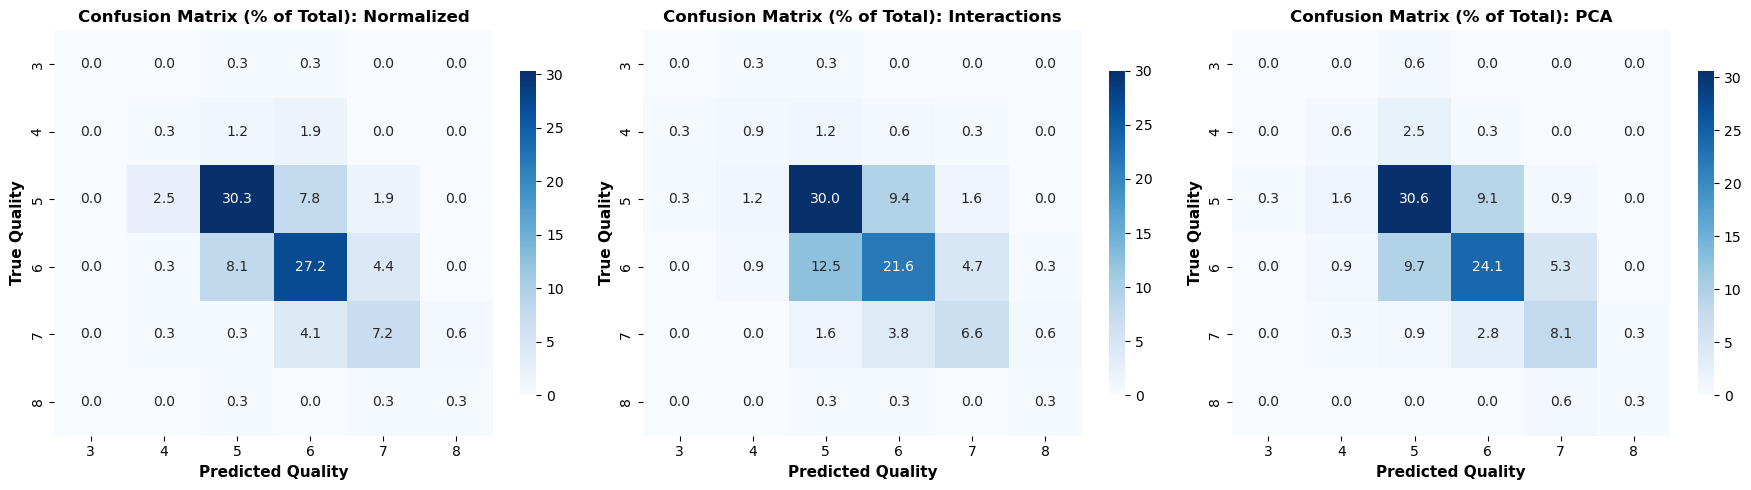

In [32]:
# Ensure figures directory exists
os.makedirs('../../figures', exist_ok=True)

# Create subplots for each dataset result
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
quality_labels = sorted(y_norm.unique())

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    
    # Normalize to percent of the whole set
    cm_percent = cm / cm.sum() * 100
    
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', ax=axes[idx],
                xticklabels=quality_labels, yticklabels=quality_labels,
                cbar_kws={'shrink': 0.8})
    
    axes[idx].set_xlabel('Predicted Quality', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Quality', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Confusion Matrix (% of Total): {name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../../figures/ann_confusion_matrices_percent.png', dpi=300)
plt.show()
